# ASL Alphabet Classifier Test


### The goal of this Sign2 variation is to experiment with using Mixup Regularization
(See "mixup: Beyond Empirical Risk Minimization" - Hongyi Zhang, Moustapha Cisse, Yann N. Dauphin, David Lopez-Pazj, 2018;  https://arxiv.org/abs/1710.09412) 

<br>

#### Datasource: 
<a href="https://www.kaggle.com/grassknoted/asl-alphabet">https://www.kaggle.com/grassknoted/asl-alphabet</a>

<br>

This is a prototype, playing with FastAI using Resnet34 to classify American Sign Language alphabet.  It's basically Notebook #2 from the MOOC on a "clean" dataset.  We get great results ... but the data is really contrived.  It's highly likely the model will overfit, however it's a good test of the library.
<br>
<br>
### Data Wrangling info
The data has been reorganized to put sign images in labelled directories, making it easy to import and sort.
We use 2 main data directories and concatenate them together.  the 2nd dataset consists of personally captured images, created using the same notebook that does inference.  We capture every frame of a video and automatically place them in the chosen directory.  The notebook will create the main directory and the label-directory if they don't exist.

<img src="../docs/images/2021-01-13_00-57.png"><br>

<br>
<br>
<HR/>
<br>
<br>

In [1]:
from datetime import datetime
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import fastai


ARCH = xresnet34  # resnet101

CHOSEN_SAMPLE_SIZE = 480 # use this to control per-category sample sizes # 1000
TEST_SET_SIZE = round(CHOSEN_SAMPLE_SIZE * 0.2)  # number of images per category to put in the test set

remove_from_sample = {
#     'A': 0.5,
#     'B': 0.6,
#     'C': 0.5,
#     'D': 0.4,
#     'E': 0.9,
# #     'L': 0.7,
#     'M': 0.8,
# #     'N': 0.9,
# #     'O': 0.75,
#     'Q': 0.75,
#     'R': 0.4,
#     'Y': 0.8 
    
#     'A': 0.7,
#     'C': 0.5,
#     'G': 0.7,

#     'H': 0.5
#     'V': 0.7
}  # fractions of original samples to keep

EPOCHS = 3  # 4
FROZEN_EPOCHS = 4  # 1
BATCH_SIZE = 16  # 16
RESOLUTION = 400  # 300

data = 'frank'
rn_addon = '_data={data}'
time = datetime.today().strftime("%Y%m%d-%H%M")
RUN_NAME = f'{time} - arch={ARCH.__name__} - samples={CHOSEN_SAMPLE_SIZE} frozen={FROZEN_EPOCHS} epochs={EPOCHS} bs={BATCH_SIZE} res={RESOLUTION} {rn_addon}'
print(f"RUN_NAME = '{RUN_NAME}'")




import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100
# plt.style.use('dark_background')

%env WANDB_WATCH=false

import wandb
from fastai.callback.wandb import *

wandb.init(project="asl-sign-language-recognition", mode='disabled')
wandb.run.name = RUN_NAME



RUN_NAME = '20210116-1824 - arch=xresnet34 - samples=480 frozen=4 epochs=3 bs=16 res=400 _data={data}'
env: WANDB_WATCH=false


In [2]:
# path = '../data/external/Training_Set'
path = '../data/frank'
# path2 = '../data/frank-ledlights-L'
path2 = None

<br>
<br>

## Check for an available GPU

In [3]:
import torch
print('CUDA available: '.ljust(28), torch.cuda.is_available())
print('CUDA device count: '.ljust(28), torch.cuda.device_count())

current_device = torch.cuda.current_device()
print('Current CUDA Device index: '.ljust(28), current_device)
# torch.cuda.device(current_device)
print('Current CUDA Device: '.ljust(28), torch.cuda.get_device_name(current_device))

CUDA available:              True
CUDA device count:           1
Current CUDA Device index:   0
Current CUDA Device:         GeForce RTX 2070 SUPER


<br>
<br>

### Check for Dataset Imbalance

In [4]:
from string import ascii_uppercase
import numpy as np
import operator
import matplotlib.pyplot as plt

image_files = {}
image_files_qty = {}

# loop through all the characters to build dictionaries of image files and quartity of each category
for c, i in zip(ascii_uppercase, np.arange(len(ascii_uppercase))):
    image_files[c] = get_image_files(path + f'/{c}')
    if path2 != None:
        image_files[c] += get_image_files(path2 + f'/{c}')

        
    l = len(image_files[c])
    image_files_qty[c] = l
    
# custom code since we don't use 'Z'
image_files.pop('J')
image_files_qty.pop('J')
image_files.pop('Z')
image_files_qty.pop('Z')

# Get the character with the largest and smallest number of entries
maxqc = max(image_files_qty, key=image_files_qty.get)
minqc = min(image_files_qty, key=image_files_qty.get)


print()
print(f'Character with the most images:   {maxqc},   with {image_files_qty[maxqc]} images')
print(f'Character with the least images:  {minqc},   with {image_files_qty[minqc]} images')
print(f'Average number of images:         {round(np.mean(list(image_files_qty.values())))}')




Character with the most images:   X,   with 3097 images
Character with the least images:  C,   with 446 images
Average number of images:         1620


<br>
<br>

## Display the number of image files for each category

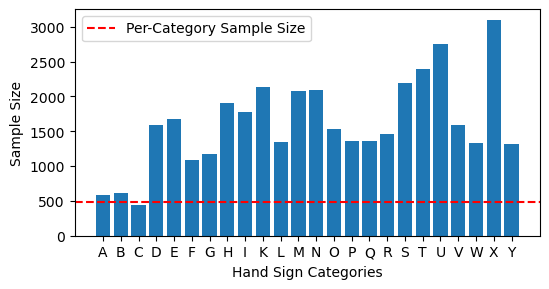

In [5]:
# plt.hist(image_files_qty.items)
plt.figure(figsize=(6,3))
plt.bar(image_files_qty.keys(), image_files_qty.values())
plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Per-Category Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size')
plt.legend();

<br>
<br>

### Balance the Dataset with Oversampling or Undersampling

Sampled size is modulated by variable `CHOSEN_SAMPLE_SIZE` and will oversample or undersample (or both) depending on the amount of data available vs the chosen sample size

In [6]:
import pandas as pd

maxq = image_files_qty[maxqc] # the quantity of the largest category
minq = image_files_qty[minqc] # the quantity of the smallest category

# all_image_files = pd.DataFrame(columns=[0])  # holds all the image files in one dataframe
train_image_files = {}
test_image_files = pd.DataFrame()

for char, q in iter(image_files_qty.items()):
    df = pd.DataFrame(data=list(image_files[char]), columns=[0])  # create a dataframe from each list
    

    # undersample or over sample as needed
    if len(df) >= CHOSEN_SAMPLE_SIZE:
        df = df.sample(CHOSEN_SAMPLE_SIZE, replace=False)  # undersample
    else:
        delta = CHOSEN_SAMPLE_SIZE - len(df)
        df = pd.concat([df, df.sample(delta, replace=(delta > len(df)))], ignore_index=True)  # oversample
        
    # siphon off the test set
    _tif = df[0].sample(TEST_SET_SIZE, replace=False)
    test_image_files[char] = _tif.reset_index(drop=True)
    
    # form  the training set
    train_image_files[char] = df[0].drop(_tif.index)
       
test_image_files = test_image_files.sample(frac=1)  # shuffle - training set is shuffled later

<br>
<br>

### Ensure the Dataset is Balanced

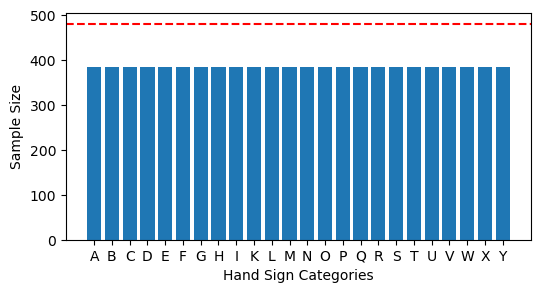

In [7]:
plt.figure(figsize=(6,3))
plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
# plt.ylim(0, CHOSEN_SAMPLE_SIZE)
plt.axhline(CHOSEN_SAMPLE_SIZE, ls='--', color='r', label='Per-Category Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample Size');

<br>
<br>

### Check the  Test Set

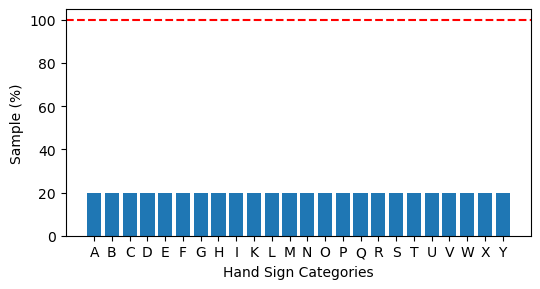

In [8]:
plt.figure(figsize=(6,3))
plt.bar(test_image_files.count().index, test_image_files.count() / CHOSEN_SAMPLE_SIZE * 100)
plt.axhline(100, ls='--', color='r', label='Per-Category Sample Size')
plt.xlabel('Hand Sign Categories')
plt.ylabel('Sample (%)');

<br>
<br>

### Deliberately Adjust the Sample Size of Certain Categories to Fine Tune the Model
Because the data is so easy to overfit and because we see certain categories fitting faster/stronger than others - causing the model to always select those categories... we try to balance that effect by decreasing the number of samples.

In [9]:
for key in remove_from_sample:
    train_image_files[key] = np.random.choice(train_image_files[key], \
                        int(remove_from_sample[key] * len(train_image_files[key])), replace=False)

<br>
<br>

### Check that the Training Dataset has been Appropriately Altered

In [10]:
if remove_from_sample != {}:
    plt.bar(train_image_files.keys(), [len(l) for l in train_image_files.values()])
    plt.xlabel('Hand Sign Categories')
    plt.ylabel('Sample Size')
    
else:
    print('\nNo dataset alterations were selected.')


No dataset alterations were selected.


<br>
<hr/>
<br>
<br>
<br>

## Model Creation and Training

<br>

<br>

### Create the DataBlock, while Resizing and Augmenting

In [11]:
import random

# Needed to pass into the DataBlock    
def get_fnames(path): 
    retlist = []

    for arr in train_image_files.values():
        for f in arr:
            retlist.append(f)
        
    return random.sample(retlist, len(retlist))
        

    
    
    
signs = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_fnames, 
    splitter=RandomSplitter(valid_pct=0.4, seed=42),
    get_y=parent_label,
    item_tfms=Resize(RESOLUTION, method='bilinear') 
   ,    batch_tfms=aug_transforms(do_flip=True, batch=True, max_zoom=1.0))


<br>
<br>

<br>

### Load the Data by Path

In [12]:
dls = signs.dataloaders(path, bs=BATCH_SIZE)
# wandb.log({'dataset':'../data/external/Training Set'})

<br>

### Verify the Training and Validation Batches

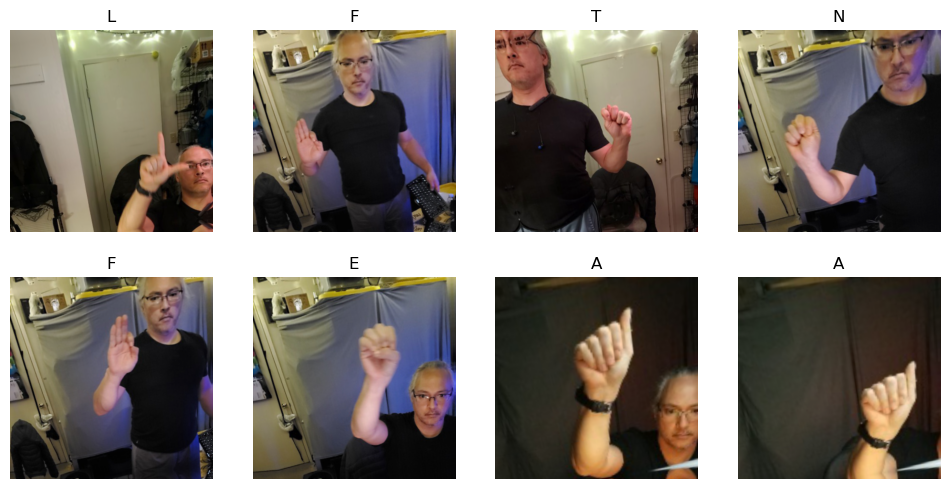

In [13]:
dls.train.show_batch(max_n=8, nrows=2)

<br>
<br>

<br>
<br>
<br>

## Create Callbacks

In [14]:
# Eary stopping callback
early_stop = EarlyStoppingCallback(monitor='error_rate', min_delta=0.01, patience=2)

# Wandb Callback for logging
wandb_cb = WandbCallback(log='all', log_dataset=False)  #, log_dataset=True)

# Mixup callback for regularization
mixup_cb = MixUp(alpha=0.4)
# mixup_cb = None

# Cutmix callback for regularization
cutmix_cb = CutMix(alpha=0.4)
# cutmix_cb = None


# List of callbacks to be used later
cbs = [ShowGraphCallback(), wandb_cb, SaveModelCallback(), early_stop]

if mixup_cb != None:
    cbs.insert(0, mixup_cb)
    
if cutmix_cb != None:
    cbs.insert(0, cutmix_cb)

print('\nAll Callbacks: ', cbs)


All Callbacks:  [CutMix, MixUp, ShowGraphCallback, WandbCallback, SaveModelCallback, EarlyStoppingCallback]


<br>
<br>

### Visualize the effect of CutMix


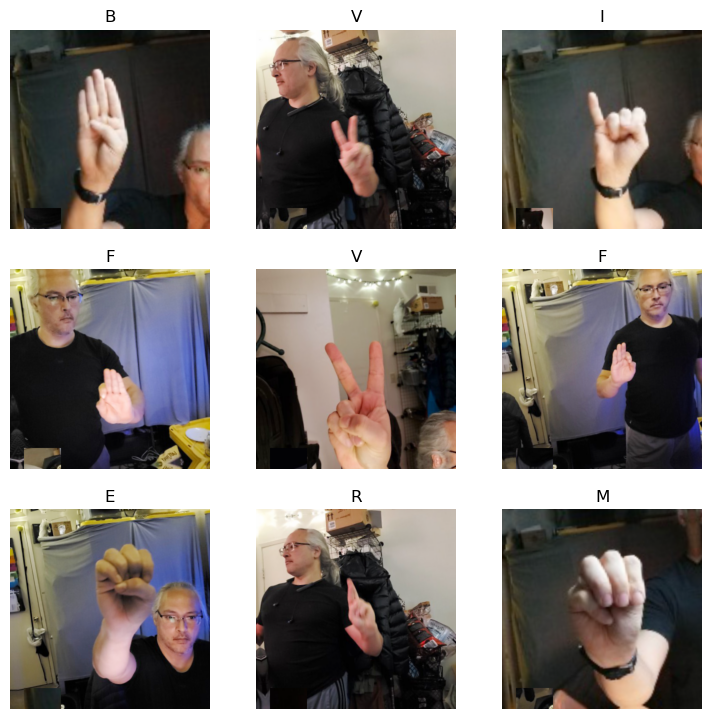

In [15]:
if cutmix_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(cutmix_cb.x,cutmix_cb.y), ctxs=axs.flatten())
    
else: print('\n CutMix was not selected.')

<br>

### Visualize the Effect of MixUp

MixUp creates a linear interpolation between the target data and another datapoint.  In images, it shows up as ghostly figures.  The technique has been shown to be a good to decrease the liklihood of overfitting.

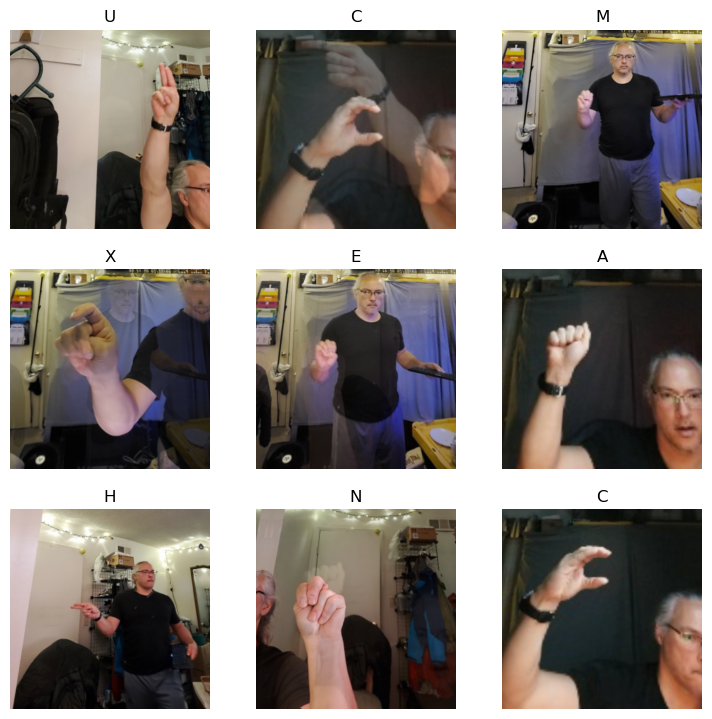

In [16]:
if mixup_cb != None:
    with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup_cb) as learn:
        learn.epoch,learn.training = 0,True
        learn.dl = dls.train
        b = dls.one_batch()
        learn._split(b)
        learn('before_batch')

    _,axs = plt.subplots(3,3, figsize=(9,9))
    dls.show_batch(b=(mixup_cb.x,mixup_cb.y), ctxs=axs.flatten())

else: print('\n MixUp was not selected.')

<br>
<br>

<br>
<br>

## Define the model and fit

In [17]:
# wandb.log()
learn = cnn_learner(dls, arch=ARCH, metrics=[error_rate, accuracy], cbs=cbs, loss_func=LabelSmoothingCrossEntropy())

<br>
<br>

### Look at the Loss Function, Optimization Function and Model Architecture

In [18]:
print('\nLoss Function: ', learn.loss_func)
print('\nOptimization Function: ', learn.opt_func)
# print('\n\n', learn.model)


Loss Function:  LabelSmoothingCrossEntropy()

Optimization Function:  <function Adam at 0x7f03f353d1f0>


<br>
<br>
<br>

## Find a Good Learning Rate to Start With

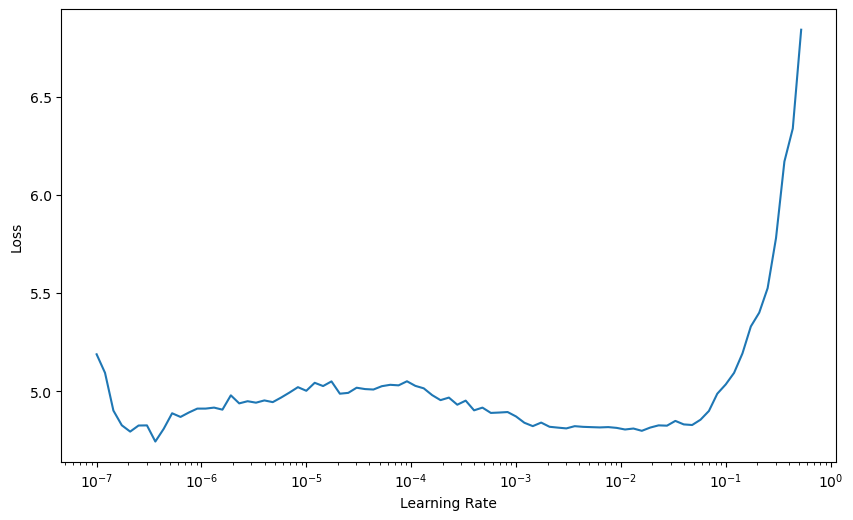

In [19]:
lr_min,lr_steep = learn.lr_find()

In [20]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.58e-03, steepest point: 1.74e-05


<br>
<br>

## Fit the last layers, unfreeze, fit the whole net, with a descriminant LR, all in one go.
Model architecture: 
Filename: ../models/{{RUN_NAME}}.pkl


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.003565,2.966654,0.784048,0.215952,01:43
1,3.569323,2.573781,0.655996,0.344004,01:44
2,3.200558,2.393645,0.598209,0.401791,01:47
3,2.945598,2.087801,0.544493,0.455507,01:49


Better model found at epoch 0 with valid_loss value: 2.966654062271118.


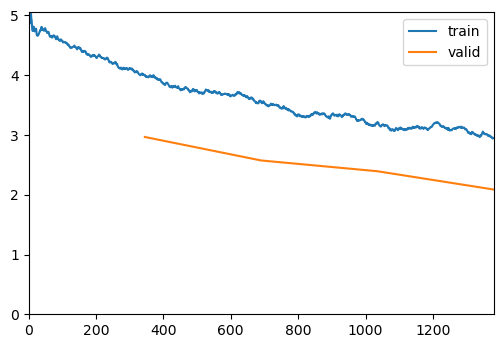

Better model found at epoch 1 with valid_loss value: 2.5737810134887695.
Better model found at epoch 2 with valid_loss value: 2.3936450481414795.
Better model found at epoch 3 with valid_loss value: 2.0878005027770996.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.829915,2.025446,0.485893,0.514107,02:23
1,2.700157,1.710285,0.389311,0.610689,02:24


Better model found at epoch 0 with valid_loss value: 2.0254461765289307.


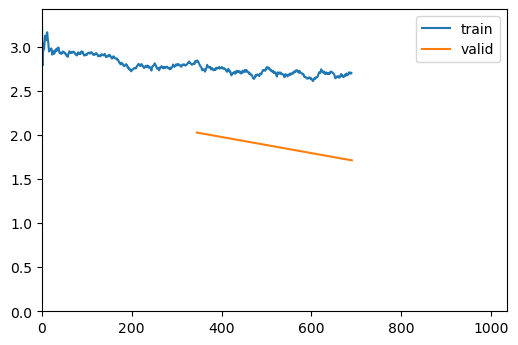

Better model found at epoch 1 with valid_loss value: 1.71028470993042.


In [ ]:
learn.fine_tune(EPOCHS, freeze_epochs=FROZEN_EPOCHS, base_lr=lr_min)

In [ ]:
# learn.fit(1, cbs=[mixup_cb, ShowGraphCallback(), early_stop])

<br>
<br>

## Persist the Model

In [ ]:
learn.export(f'../models/{RUN_NAME}.pkl')
# path = Path('../models')
# path.ls(file_exts='.pkl')

<br>
<br>

### Show some Results

In [ ]:
learn.show_results()

<br>
<hr>
<br>
<br>
<br>

## Validation Set (not the holdout) Analysis

<br>

### Plot Losses

In [ ]:
# learn.recorder.plot_loss()
# plt.ylabel('Loss')
# plt.xlabel('Batches Processed')

<br>

### Visualize with a confusion Matrix

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>

### Show the top 15 most error prone images

In [ ]:
interp.plot_top_losses(15, nrows=3)

<br>
<br>

<br>

### ~~Clean the images that were hard to interpret and obviously bad~~

(I had to remove this section as it was using too much RAM and crashing the kernel)

### Show a Widget that allows us to mark poor exemplars for deletion

In [ ]:
# import gc
# cleaner = None
# gc.collect()

# cleaner = ImageClassifierCleaner(learn)
# cleaner

### Show the Indexes of the images we want to delete

In [ ]:
# cleaner.delete()

### Delete the files

In [ ]:
# import os

# for idx in cleaner.delete():
#     print(f'removing: {str(cleaner.fns[idx])}')
#     os.remove(str(cleaner.fns[idx]))

<br>
<br>
<hr>
<br>
<br>




<br>
<br>

## Test Set Validation

<br>

In [ ]:
test_learn = learn

import gc
cleaner = None
# learn = None
gc.collect()

In [ ]:
# learn = load_learner(f'../models/20210115-0815 - arch=resnet50 - samples=4000 frozen=1 epochs=1 bs=30 res=300 _throwaway.pkl', cpu=False)
# learn=load_learner(f'../models/20210114-1202 - arch=resnet101 - samples=4000 frozen=1 epochs=2 bs=16 res=300 _throwaway.pkl', cpu=False)
# test_learn = load_learner(f'../models/{RUN_NAME}.pkl', cpu=False)

In [ ]:
def get_test_fnames(path):
    return list(test_image_files.values.flatten())

In [ ]:
path

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_test_fnames,
    get_y=parent_label, 
    item_tfms=Resize(RESOLUTION, method='bilinear')) #,



dls = test_db.dataloaders(path, bs=BATCH_SIZE)

test_dl = dls.test_dl(get_test_fnames('None'), with_labels=True)

<br>
<br>

####  Get the Inferrences on the Test Set

In [ ]:
inputs, preds, targs, decoded, losses = test_learn.get_preds(dl=test_dl, with_input=True, with_decoded=True, with_loss=True)


In [ ]:
interp = ClassificationInterpretation(dl=test_dl, inputs=inputs, preds=preds, targs=targs, decoded=decoded, losses=losses )

<br>

### Visualize with a confusion Matrix

In [ ]:
# interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8,8))

In [ ]:
interp.most_confused()[:10]

<br>
<br>

## Classification Report

In [ ]:
interp.print_classification_report()

<br>
<br>
<br>

## Clean up

<br>

In [ ]:
wandb.join()

In [ ]:
wandb.finish()

<br>
<br>
<br>
<hr>
<br>

# Log

* started to plot the learning rates and started to use that information while fitting.
* Downgraded to resnet34 @ 300px in order to increase the resolution fed to the model from 128px to 300px - this made a major difference.
* Decreased the number of training epochs to 6 after experimenting to find the sweet spot. - also positive change
* Changed to exclusively use fine-tune() with it's built in freeze_epochs parameter
* Changed the Batch Size in order to bring the arch back to resnet101 @300px
* Cleaned up the markdown, removed cells and reordered the rest.
* Added an Early Stop.  Starting with 0.01 delta.  
* Now moving to 0.1 delta
* Integrated wandb to keep track of experiments.
* added section to balance the dataset through oversampling.

** Attempting a batch size of 12 and 384px with resnet101.  long training times.
** Also increased the epochs to 4 on the final layer and 7 on the rest.
    

In [ ]:
# learn.unfreeze()

In [ ]:
# learn.fine_tune(epochs=2, freeze_epochs=1, base_lr=high)
#                 cbs=[mixup_cb, ShowGraphCallback(), SaveModelCallback(), early_stop])

In [ ]:
# low, high = learn.lr_find()

In [ ]:
# low

In [ ]:
# high

## Archive this version of the notehook

In [ ]:
import os
import shutil

# Allow Jupyter the opportunity to autosave
!sleep 20

# copy the notebook file - the prefix links it to the saved model
shutil.copyfile('Sign2 - Implementing Mixup.ipynb', f'.Archive/{time} - Sign2 - Implementing Mixup.ipynb')